### The purpose of this notebook is to explore how using the Arrest data stored in the "Stop Resolution" column changes the outcome of the model. It has recently come to my attention that the number of Arrests reported in the "Stop Resolution" column does not match thte "Arrest Flag" column and because of this another model needed to be created.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from pandas_profiling import ProfileReport

from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTEN

from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve

from numpy import sqrt
from numpy import argmax

In [2]:
df = pd.read_csv('./Data/Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00.0000000,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00.0000000,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00.0000000,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00.0000000,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00.0000000,-,-,-,NaN,N,N,-,-,-


### Immediately converting Arrests to a Boolean value in it's own column.

In [3]:
df['Stop Resolution'].value_counts()

Field Contact               22342
Offense Report              16502
Arrest                      12951
Referred for Prosecution      728
Citation / Infraction         189
Name: Stop Resolution, dtype: int64

In [5]:
df['Arrest'] = df['Stop Resolution'] == 'Arrest'

In [7]:
arrest_map = { True : 1, False : 0}

In [8]:
df['Arrest'] = df['Arrest'].map(arrest_map)

In [10]:
df.Arrest.value_counts()

False    39761
True     12951
Name: Stop Resolution, dtype: int64

### Dropping all column that were deemed irrelevant or multicolinear in the previous notebook

In [17]:
df = df.drop(['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Stop Resolution', 'Officer ID', 'Initial Call Type', 'Final Call Type', 'Call Type', 'Reported Date', 'Beat', 'Precinct'], axis=1)

KeyError: "['Subject ID' 'GO / SC Num' 'Terry Stop ID' 'Stop Resolution' 'Officer ID'\n 'Initial Call Type' 'Final Call Type' 'Call Type' 'Reported Date' 'Beat'\n 'Precinct'] not found in axis"

In [19]:
df = df.drop("Arrest Flag", axis = 1)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51746 entries, 0 to 52711
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         51746 non-null  object 
 1   Weapon Type               51746 non-null  object 
 2   Officer Gender            51746 non-null  object 
 3   Officer Race              51746 non-null  object 
 4   Subject Perceived Race    51746 non-null  object 
 5   Subject Perceived Gender  51746 non-null  object 
 6   Frisk Flag                51746 non-null  float64
 7   Sector                    51746 non-null  object 
 8   Arrest                    51746 non-null  int64  
 9   Officer_YOB_Bins          51746 non-null  object 
 10  hour                      51746 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 4.7+ MB


### Converting all column to the correct type

In [13]:
frisk_map = {'Y' : 1, 'N' : 0}

In [15]:
df['Frisk Flag'] = df['Frisk Flag'].map(frisk_map)

In [22]:
df['Officer_YOB_Bins'] = pd.cut(
   df['Officer YOB'], 
   [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
)

In [23]:
df.dropna(inplace=True)

In [24]:
df = df.drop('Officer YOB', axis = 1)

In [26]:
df.Officer_YOB_Bins = df.Officer_YOB_Bins.astype('object')

In [27]:
df['hour'] = df['Reported Time'].str[:2]

In [32]:
df['hour'] = df['hour'].astype('int')

In [29]:
df = df.drop('Reported Time', axis = 1)

In [30]:
df = df.drop('Officer Squad', axis = 1)

### Train Test Split

In [34]:
y = df['Arrest']
X = df.drop('Arrest', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [35]:
y_train.value_counts(normalize=True)

0    0.754232
1    0.245768
Name: Arrest, dtype: float64

### Creation of my Pipeline with my best performing model attached

In [36]:
subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(missing_values='Unknown', strategy='most_frequent', add_indicator = True)),
    ('cat_impute2', SimpleImputer(missing_values='-', strategy='most_frequent', add_indicator = True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [37]:
CT = ColumnTransformer(transformers=[
    ('subpipe_cat', subpipe_cat, selector(dtype_include=[object, int]))
], remainder='passthrough')

In [38]:
imb_pipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTEN(sampling_strategy=0.8, random_state=42)),
    ('log', LogisticRegression(random_state=42, max_iter=1000))
])

In [39]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values='Unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('cat_impute2',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values='-',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41493c100>)])),
                ('sm', SMOTEN(random_state=42, sampling_strategy=0.8)),
                ('log', LogisticRegression(max_iter=1000, random_state=42))])

In [40]:
y_hat = imb_pipe.predict(X_test)

In [41]:
print(f"""
Our model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our model's accuracy on the test set is 0.75. 

Our model's recall on the test set is 0.09 

Our model's precision on the test set is 0.52 

Our model's f1-score on the test is 0.16.



well well well.. who would have guessed... some things never change.

/Users/jordanmang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


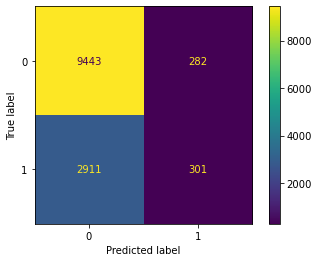

In [42]:
plot_confusion_matrix(imb_pipe, X_test, y_test);

Somehow with more arrest data it performed even worse.. its starting to really feel like there aren't enough features or arent the correct features to do this prediction.

### EDA using these new numbers

In [53]:
race_arrest = df.groupby(['Subject Perceived Race', 'Arrest']).size().unstack(fill_value=0)
race_arrest

Arrest,0,1
Subject Perceived Race,,
-,1536,192
American Indian or Alaska Native,1041,423
Asian,1261,471
Black or African American,11105,4299
Hispanic,1260,396
Multi-Racial,630,159
Native Hawaiian or Other Pacific Islander,66,25
Other,108,40
Unknown,2653,708


In [54]:
race_arrest.sum()

Arrest
0    38996
1    12750
dtype: int64

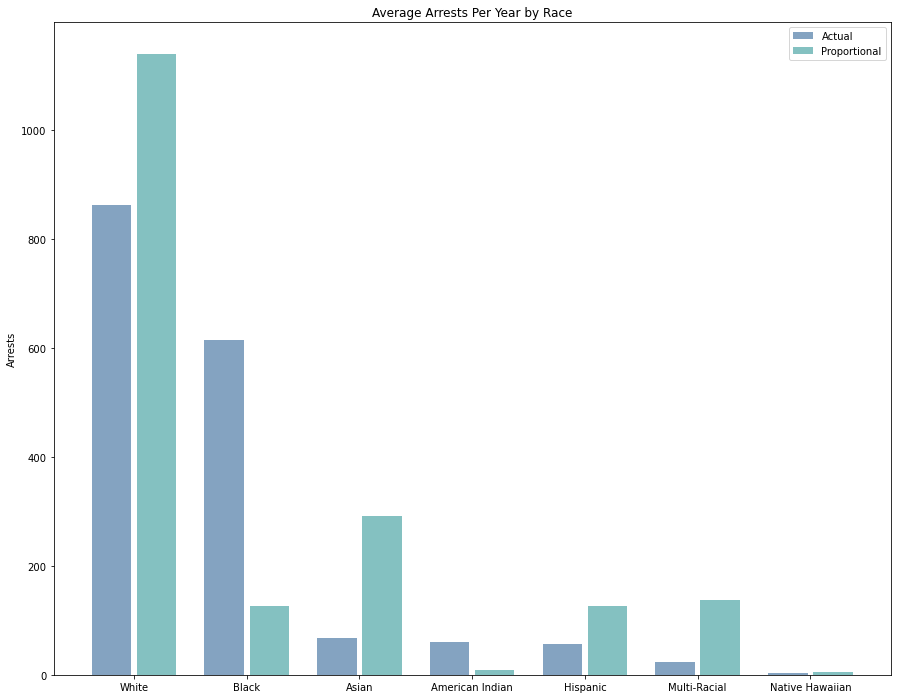

In [142]:
labels = [ 'American Indian', 'Asian', 'Black', 'Hispanic', 'Multi-Racial', 'Native Hawaiian', 'White']
prop_count = [ 64, 2040, 893, 893, 969, 38, 7981]
prop_count_year = [ 9, 291, 127, 127, 138, 5, 1140]
count = [ 423, 471, 4299, 396, 159, 25, 6037]
count_year = [ 60, 67, 614, 56, 23, 4, 862]
labels_order = ['White', 'Black', 'Asian', 'American Indian', 'Hispanic', 'Multi-Racial', 'Native Hawaiian']
count_year_order= [862, 614, 67, 60, 56, 23, 4]
prop_count_year_order= [1140, 127, 291, 9, 127, 138, 5]

x_axis = np.arange(len(labels_order))
fig, ax = plt.subplots(figsize=(15,12))
# Multi bar Chart

plt.bar(x_axis -0.2, count_year_order, width, label='Actual', color=(0.2, 0.4, 0.6, 0.6))
plt.bar(x_axis +0.2, prop_count_year_order, width, label='Proportional', color=(0.2, 0.6, 0.6, 0.6))

# Xticks

plt.xticks(x_axis, labels_order)
plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
# Add legend

plt.legend()

# Display

ax.set_ylabel('Arrests')
ax.set_title('Average Arrests Per Year by Race')
ax.legend()

plt.show()

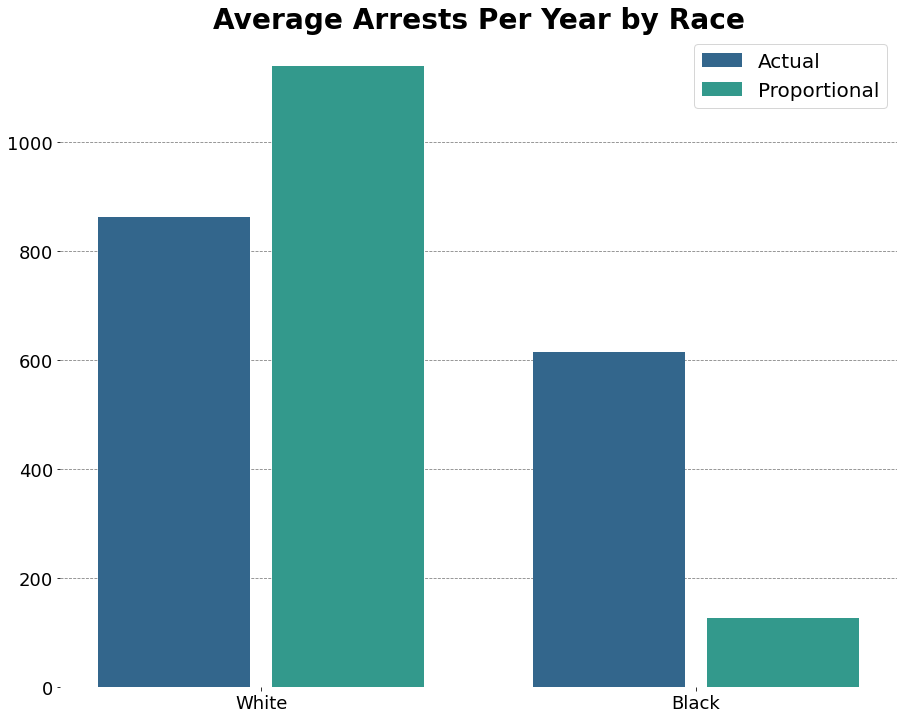

In [191]:
labels = [ 'American Indian', 'Asian', 'Black', 'Hispanic', 'Multi-Racial', 'Native Hawaiian', 'White']
prop_count = [ 64, 2040, 893, 893, 969, 38, 7981]
prop_count_year = [ 9, 291, 127, 127, 138, 5, 1140]
count = [ 423, 471, 4299, 396, 159, 25, 6037]
count_year = [ 60, 67, 614, 56, 23, 4, 862]
labels_order = ['White', 'Black']
count_year_order= [862, 614]
prop_count_year_order= [1140, 127]

x_axis = np.arange(len(labels_order))
fig, ax = plt.subplots(figsize=(15,12))
# Multi bar Chart

plt.bar(x_axis -0.2, count_year_order, width, label='Actual', color=(0.2, 0.4, 0.55, 1))
plt.bar(x_axis +0.2, prop_count_year_order, width, label='Proportional', color=(0.2, 0.6, 0.55, 1))

# Xticks
plt.xticks(x_axis, labels_order, size=18)
plt.yticks(size=18)
plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
# Add legend

plt.legend()

# Display
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_ylabel('Arrests')
ax.set_title('Average Arrests Per Year by Race', size=28,fontweight="bold")
#ax.grid(axis = 'y')

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.legend(prop={'size': 20})

plt.show()

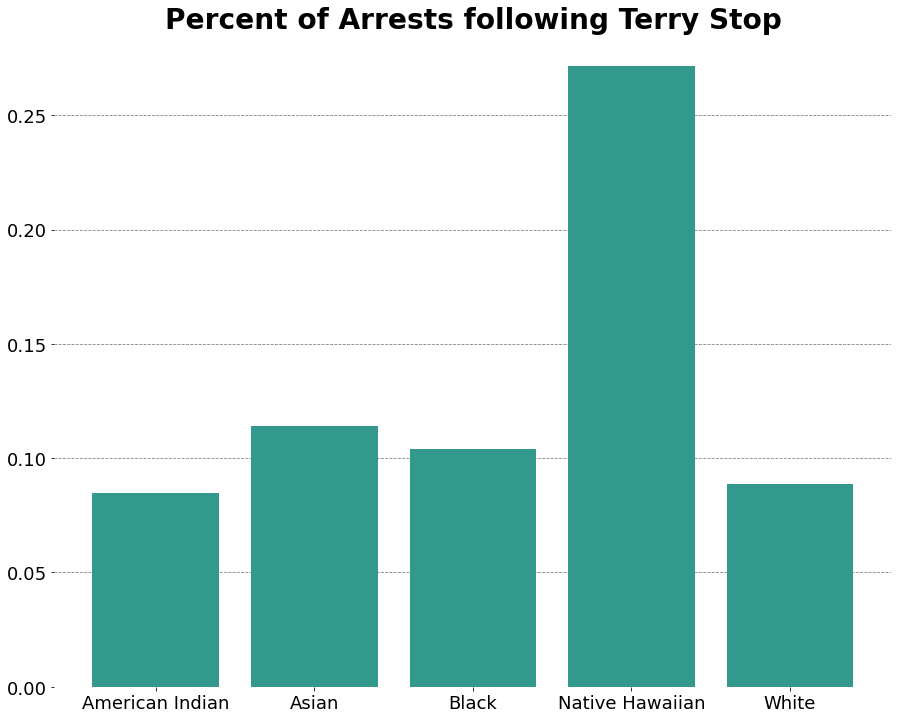

In [201]:
fig, ax = plt.subplots(figsize=(15,12))
race = ['American Indian', 'Asian', 'Black', 'Native Hawaiian', 'White']
percentage = [0.084564, 0.113946, 0.103904, 0.271739, 0.088529]

plt.bar(race, percentage, color=(0.2, 0.6, 0.55, 1))

ax.set_title('Percent of Arrests following Terry Stop', size=28,fontweight="bold")

plt.xticks(size=18)
plt.yticks(size=18)

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False);